In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## DATABASE CONNECTION

In [3]:
DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


In [4]:
query = """
SELECT 
    td.id,
    td.departure_date,
    td.train_number,
    td.relation,
    td.train_service,
    td.ptcar_number,
    td.line_number_departure,
    td.real_time_arrival,
    td.real_time_departure,
    td.planned_time_arrival,
    td.planned_time_departure,
    td.delay_arrival,
    td.delay_departure,
    ptcar.id AS ptcar_id,     
    ptcar.name AS name_travel,    
    td.line_number_arrival,
    dep.name AS departure_station_name,
    arr.name AS arrival_station_name,
    ptcar.longitude AS ptcar_longitude,  
    ptcar.latitude AS ptcar_latitude  
FROM train_data td
JOIN STATIONS ptcar ON td.ptcar_name = ptcar.id
JOIN STATIONS dep ON td.station_departure = dep.id
JOIN STATIONS arr ON td.station_arrival = arr.id
WHERE td.station_arrival = '487'  
  AND td.station_departure = '159'  
ORDER BY td.id;
"""

line = pd.read_sql(sqla.text(query), connection)

line =line.drop(columns=['train_service', 'relation'])

print(line.head())
print(line.shape)

         id departure_date  train_number  ptcar_number line_number_departure  \
0  24603914     2014-12-14          2103            70                   162   
1  24603915     2014-12-14          2104            70                   162   
2  24603916     2014-12-14          2105            70                   162   
3  24603917     2014-12-14          2106            70                   162   
4  24603918     2014-12-14          2108           220                   0/3   

  real_time_arrival real_time_departure planned_time_arrival  \
0              None            06:32:31                 None   
1              None            07:30:12                 None   
2              None            08:30:14                 None   
3              None            09:32:41                 None   
4              None            08:45:07                 None   

  planned_time_departure  delay_arrival  delay_departure  ptcar_id  \
0               06:32:00            0.0             31.0        

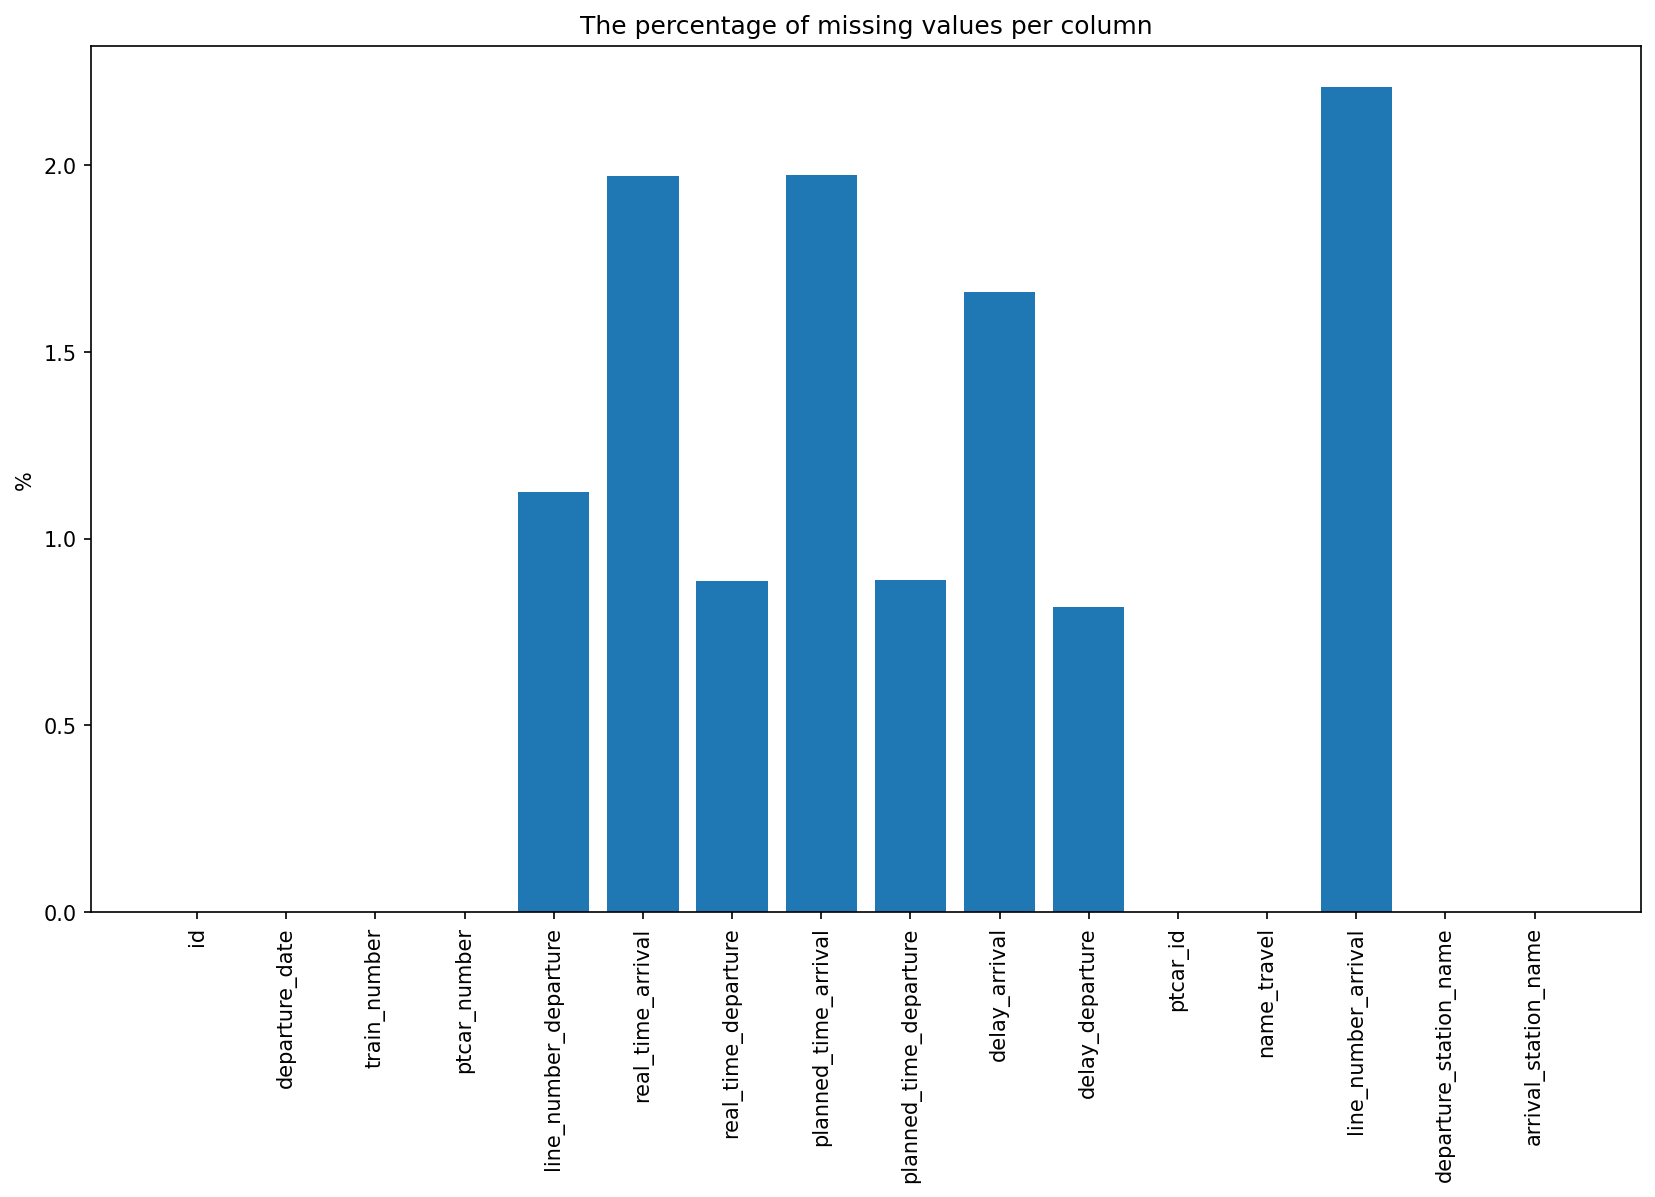

In [4]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.bar(line.columns, line.isna().sum() / line.shape[0] * 100)
plt.xticks(rotation=90)
plt.ylabel("%")
plt.title("The percentage of missing values per column")
plt.show()

In [15]:
print(line['ptcar_id'].unique())

[ 70 159 151 149 150 156 157 154 245 773 132 310 365 422 300 628 614 591
 540 118 178 235 281 480 108 642 624 623 557 558 384 199 559 645 195  73
 261 560 187 438 172 342 341  80 503 388 267 313 608 339 452 564 493 317
 704 757 646 331 209 794 575 415 416 237 740 352 445 362 593 690 601 264
  69 276  91 774 111 469 592 383 485 305 792 215  20 282 371  94 279 278
 309 168 598 106 263 754 319  77  75 527 583 143 589  95 501   5 100 327
 428 218 289 205 525 513 656 247 130 330 448 625 171 509 389 551 550 271
 262 256 632 170 196 253 426 752 726 727 465 260 474 176 177 192 180 434
 252   9 710  79 392 391 323 161  28 751 328 119 604 166 508  21 731 521
 515 421 780 672 681 437   2 234 207 454 633 668 659 661 663 655 664 662
 123 487 158 683 720 552 629 586 587 588 495 496 556 678 179  14 386  89
 703 374  12  11 340 355 231 259 257 680 596 406 405  18 724 526 368 241
 612 627 626 190 325 709 125  88 517 494  17 660 489 753 232 366 361 129
 314 315 779 324 785 174 658]


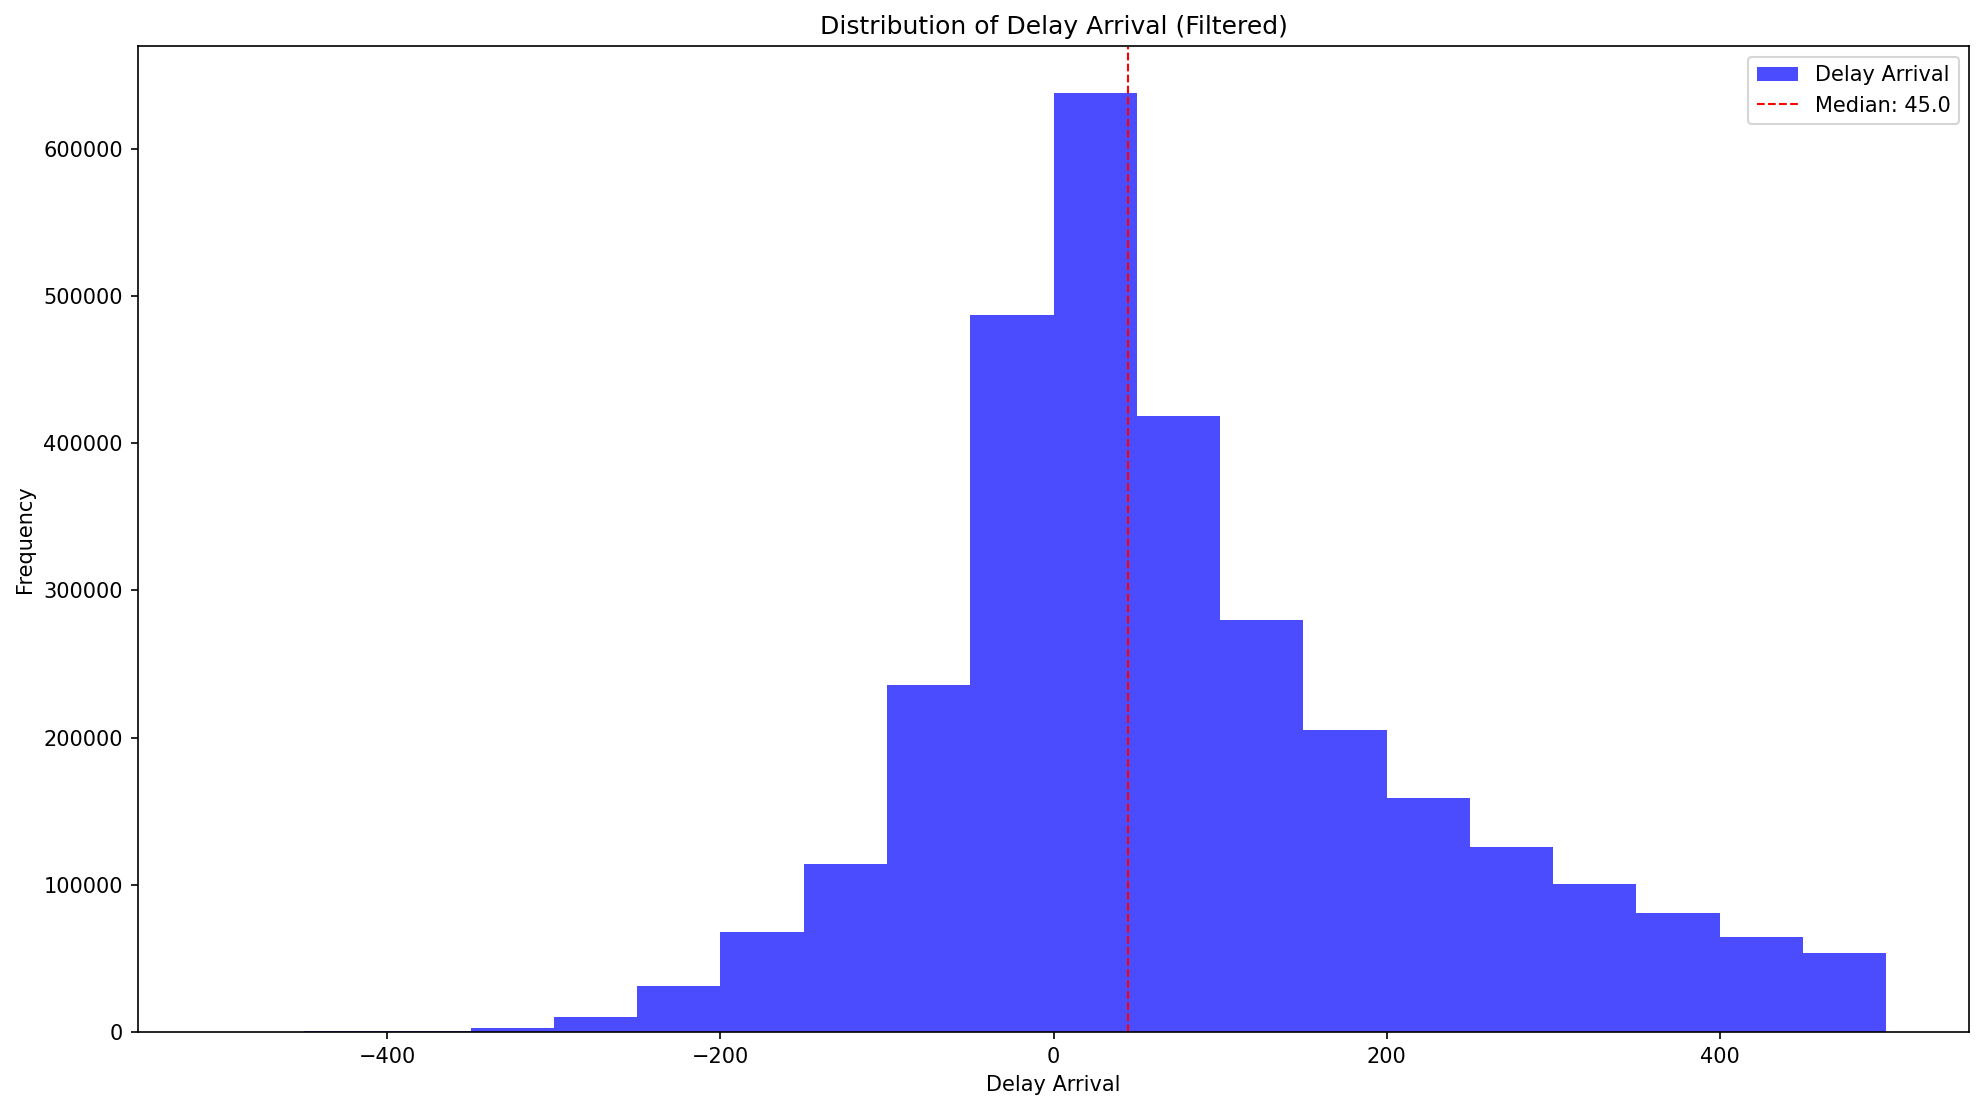

In [6]:
filtered = line[(line['delay_arrival'] >= -500) & (line['delay_arrival'] <= 500)]

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.hist(filtered['delay_arrival'], bins=20, color='blue', alpha=0.7, label='Delay Arrival')
ax.axvline(filtered['delay_arrival'].median(), color='red', linestyle='dashed', linewidth=1, label='Median: ' + str(round(filtered['delay_arrival'].median(), 2)))
ax.set_xlabel('Delay Arrival')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Delay Arrival (Filtered)')
ax.legend()
plt.tight_layout()
plt.show()

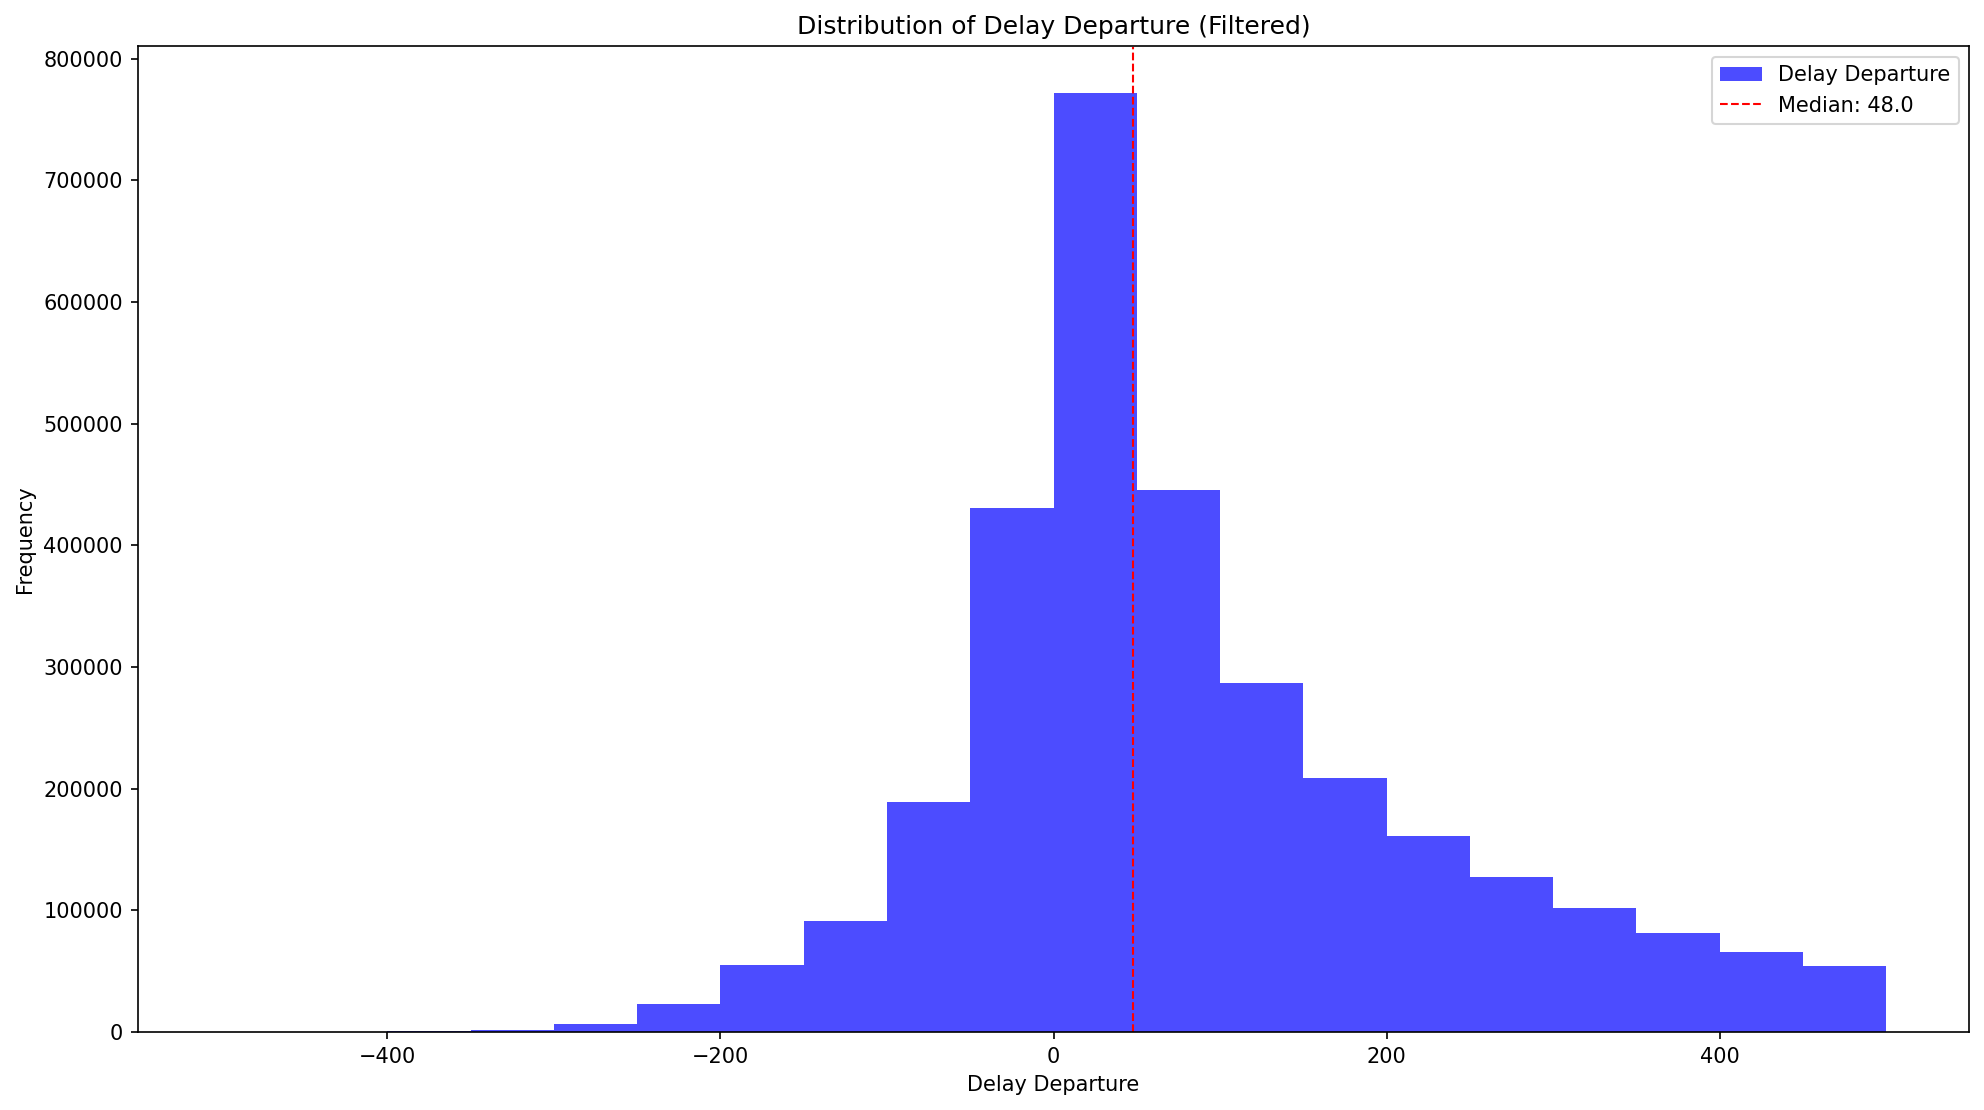

In [7]:
filtered = line[(line['delay_departure'] >= -500) & (line['delay_departure'] <= 500)]
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.hist(filtered['delay_departure'], bins=20, color='blue', alpha=0.7, label='Delay Departure')
ax.axvline(filtered['delay_departure'].median(), color='red', linestyle='dashed', linewidth=1, label='Median: ' + str(round(filtered['delay_departure'].median(), 2)))
ax.set_xlabel('Delay Departure')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Delay Departure (Filtered)')
ax.legend()
plt.tight_layout()
plt.show()

           name_travel  avg_delay_departure
0            OTTIGNIES                118.0
1             MARBEHAN                109.0
2          RHISNES-SAS                106.0
3             BLANMONT                104.0
4      BRUSSEL-SCHUMAN                104.0
5   MONT-SAINT-GUIBERT                101.0
6              CHASTRE                 97.0
7  SAINT-DENIS-BOVESSE                 97.0
8              LEIGNON                 96.0
9               ERNAGE                 96.0


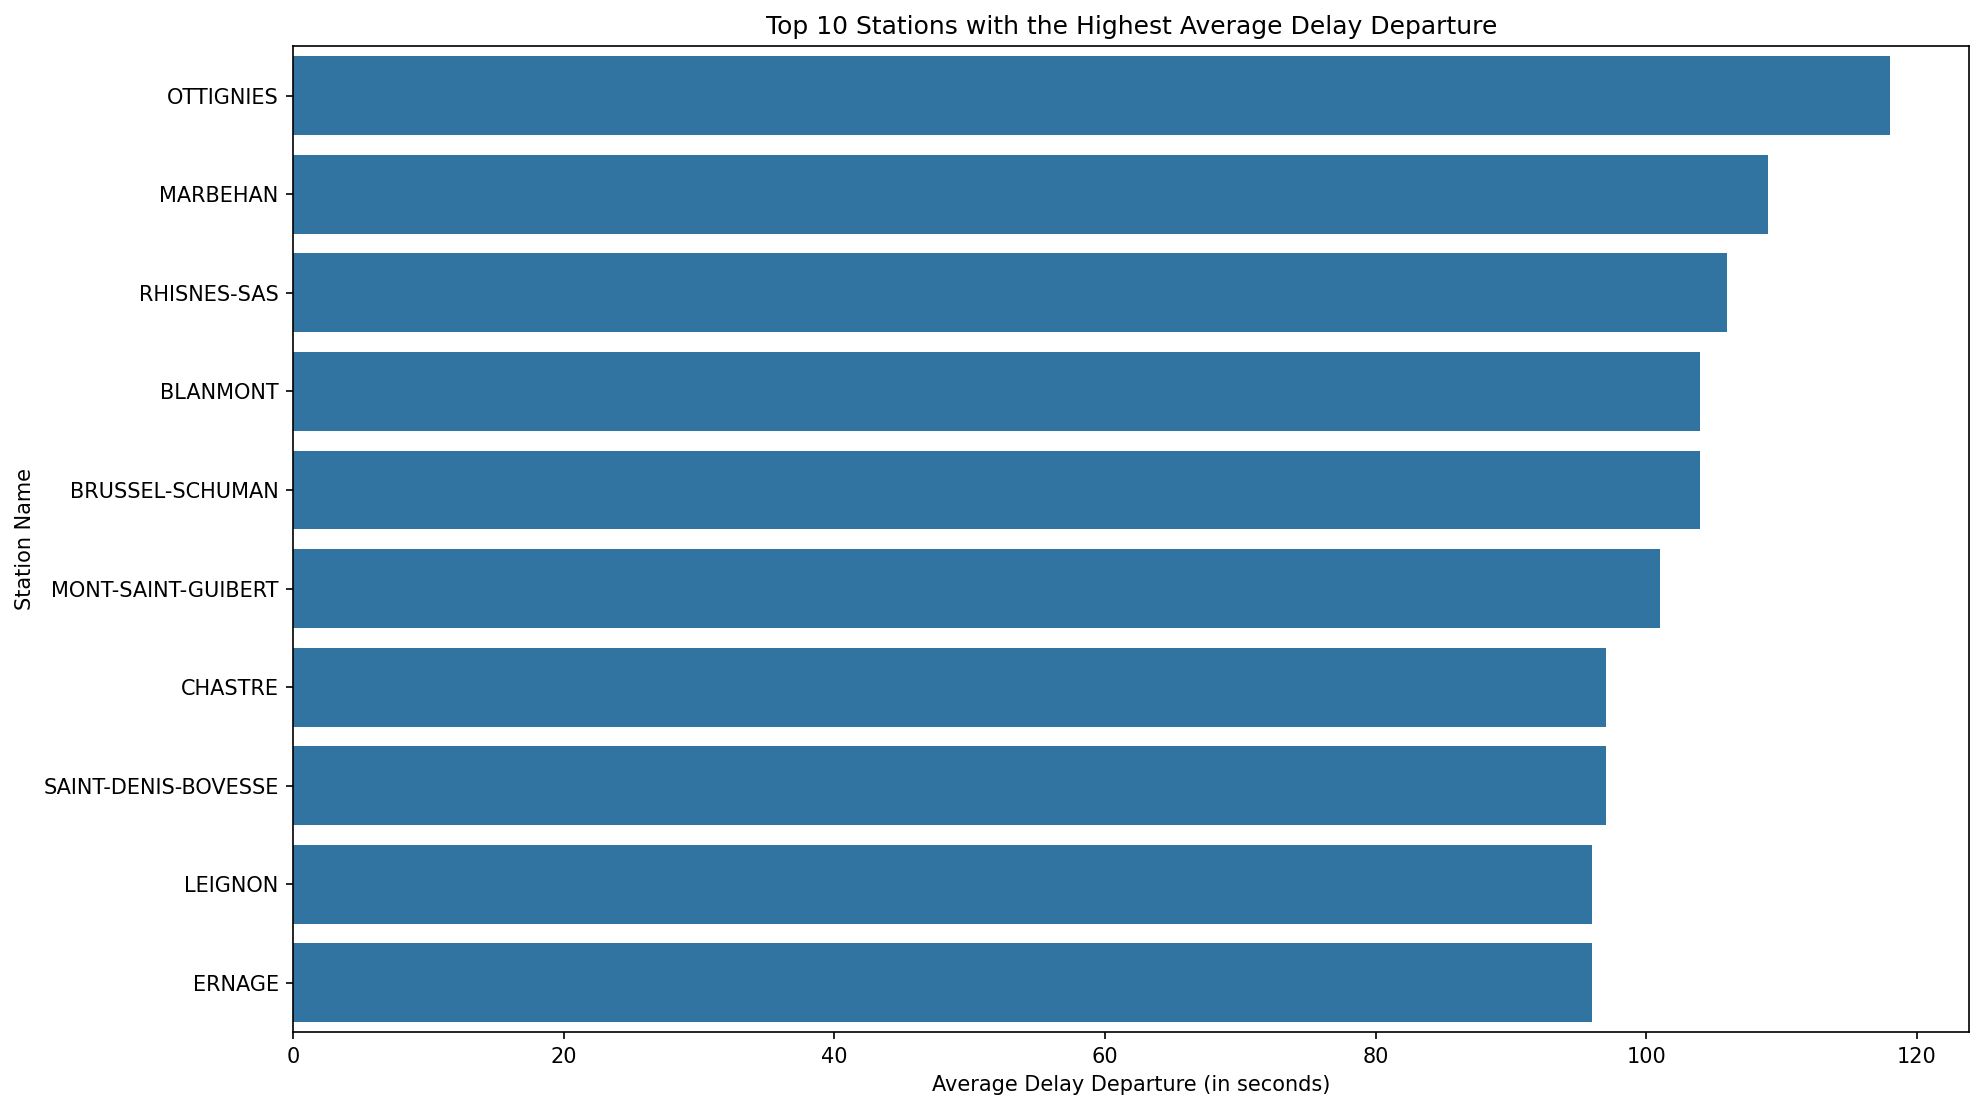

In [9]:
without_na = line.dropna(subset=["delay_departure"])
ptcar_counts = without_na["name_travel"].value_counts()
valid_ptcars = ptcar_counts[ptcar_counts > 10_000].index
without_na = without_na[without_na["name_travel"].isin(valid_ptcars)]


top_delay_stations = (without_na.groupby("name_travel")["delay_departure"].median().sort_values(ascending=False).head(10).reset_index())

top_delay_stations.columns = ["name_travel", "avg_delay_departure"]
print(top_delay_stations)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
sns.barplot(data=top_delay_stations, x="avg_delay_departure", y="name_travel")
plt.xlabel("Average Delay Departure (in seconds)")
plt.ylabel("Station Name")
plt.title("Top 10 Stations with the Highest Average Delay Departure")
plt.tight_layout()


   name_travel  pct_late_departure
0      JEMELLE           27.481522
1     MARBEHAN           26.303610
2      VIVILLE           24.829843
3      LEIGNON           24.620682
4    FORRIERES           24.168675
5  RHISNES-SAS           24.082422
6        CINEY           24.046336
7      GRUPONT           23.890986
8    OTTIGNIES           23.696874
9      STOCKEM           23.691585


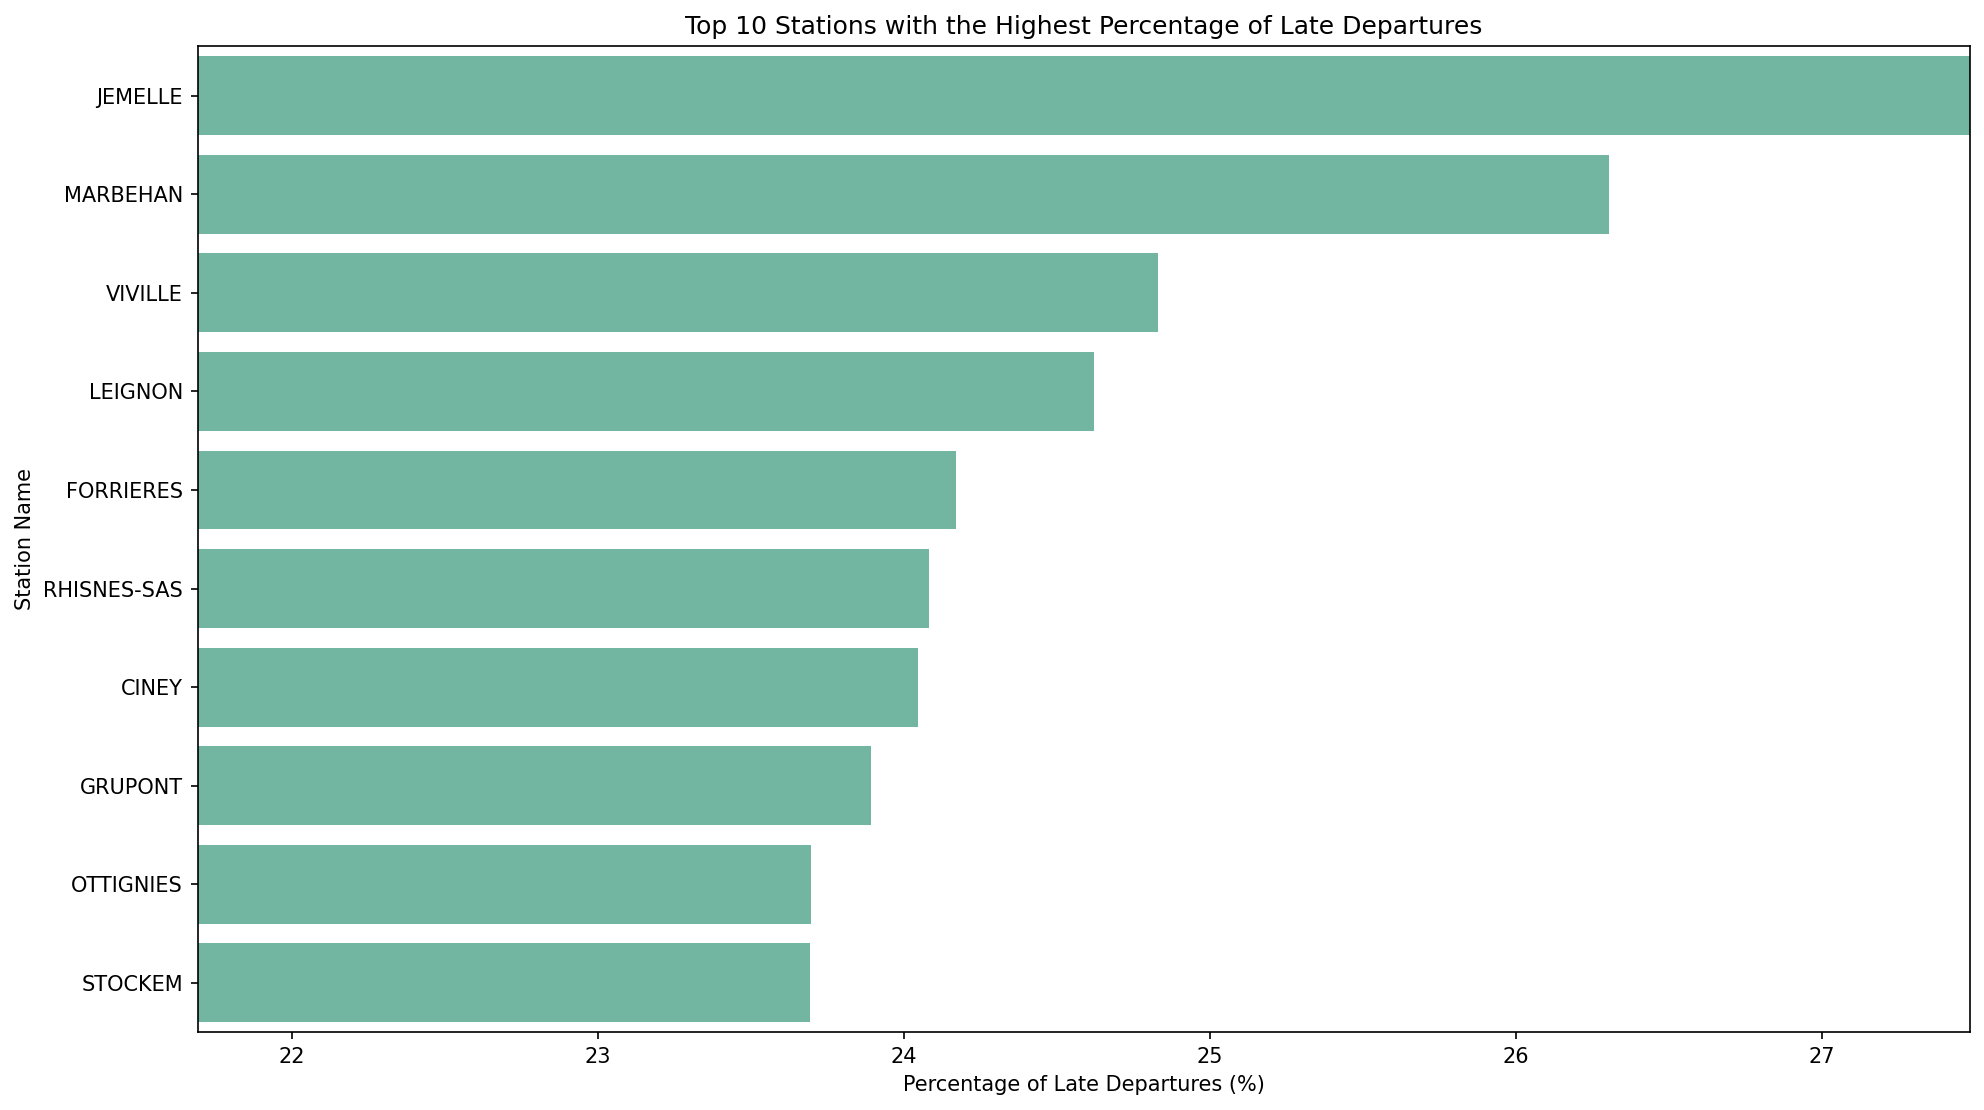

In [10]:
without_na = line.dropna(subset=["delay_departure"])

ptcar_counts = without_na["name_travel"].value_counts()
valid_ptcars = ptcar_counts[ptcar_counts > 10_000].index
without_na = without_na[without_na["name_travel"].isin(valid_ptcars)]

without_na["is_late"] = without_na["delay_departure"] > 300

delay_ratio = (
    without_na.groupby("name_travel")["is_late"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

delay_ratio.columns = ["name_travel", "pct_late_departure"]
delay_ratio["pct_late_departure"] *= 100  
print(delay_ratio)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
sns.barplot(data=delay_ratio, x="pct_late_departure", y="name_travel", palette="Set2", hue=1, legend=False)
plt.xlabel("Percentage of Late Departures (%)")
plt.ylabel("Station Name")
plt.title("Top 10 Stations with the Highest Percentage of Late Departures")
plt.xlim(delay_ratio["pct_late_departure"].min() -2, delay_ratio["pct_late_departure"].max())
plt.tight_layout()
plt.show()

In [5]:
road = [159,151,149,150,156,157,154,245,773,132,310,365,422,300,628,614,591,
 540,118,178,235,281,480,108,642,625,623,557,558,384,199,559,645,123,195,73,
 261,560,187,438,172,342,341,80,503,629,267,313,608,339,452,564,493,
 317,704,757,70]

print("Road:", len(road))

tempo = []
clean = []
road_index = 0

for i, row in line.iterrows():
    ptcar_id = row['ptcar_id']
    if ptcar_id == road[road_index]:
        tempo.append(row)
        road_index += 1
        if len(tempo) == len(road):
            clean.extend(tempo)
            tempo = []
            road_index = 0
    else:
        tempo = []
        road_index = 0

clean_df = pd.DataFrame(clean)

print(len(clean_df))
print(clean_df.head())



Road: 57
1558950
              id departure_date  train_number  ptcar_number  \
924915  77956571     2017-06-11          2119           220   
924916  77956572     2017-06-11          2119           217   
924917  77956573     2017-06-11          2119           215   
924918  77956574     2017-06-11          2119           216   
924919  77956575     2017-06-11          2119           221   

       line_number_departure real_time_arrival real_time_departure  \
924915                   0/1              None            19:35:25   
924916                   0/1          19:37:30            19:37:30   
924917                   0/1          19:38:48            19:39:51   
924918                   0/1          19:41:36            19:41:36   
924919                   36N          19:43:27            19:45:12   

       planned_time_arrival planned_time_departure  delay_arrival  \
924915                 None               19:33:00            NaN   
924916             19:35:00               19:

In [6]:
query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)

print(type_day.head())

         date  holiday  weekend  day_after_rest
0  2014-01-01        2    False           False
1  2014-01-02        1    False           False
2  2014-01-03        1    False           False
3  2014-01-04        1     True           False
4  2014-01-05        1     True           False


In [7]:
clean_df= clean_df.drop(columns=['departure_station_name','arrival_station_name','id', 'name_travel', 'ptcar_number','ptcar_id'])

In [8]:
print(clean_df.head())

merged_df = pd.merge(clean_df, type_day, left_on='departure_date', right_on='date', how='left')
print(merged_df.head())

       departure_date  train_number line_number_departure real_time_arrival  \
924915     2017-06-11          2119                   0/1              None   
924916     2017-06-11          2119                   0/1          19:37:30   
924917     2017-06-11          2119                   0/1          19:38:48   
924918     2017-06-11          2119                   0/1          19:41:36   
924919     2017-06-11          2119                   36N          19:43:27   

       real_time_departure planned_time_arrival planned_time_departure  \
924915            19:35:25                 None               19:33:00   
924916            19:37:30             19:35:00               19:35:00   
924917            19:39:51             19:36:00               19:37:00   
924918            19:41:36             19:39:00               19:39:00   
924919            19:45:12             19:41:00               19:43:00   

        delay_arrival  delay_departure line_number_arrival  ptcar_longitude  \
9

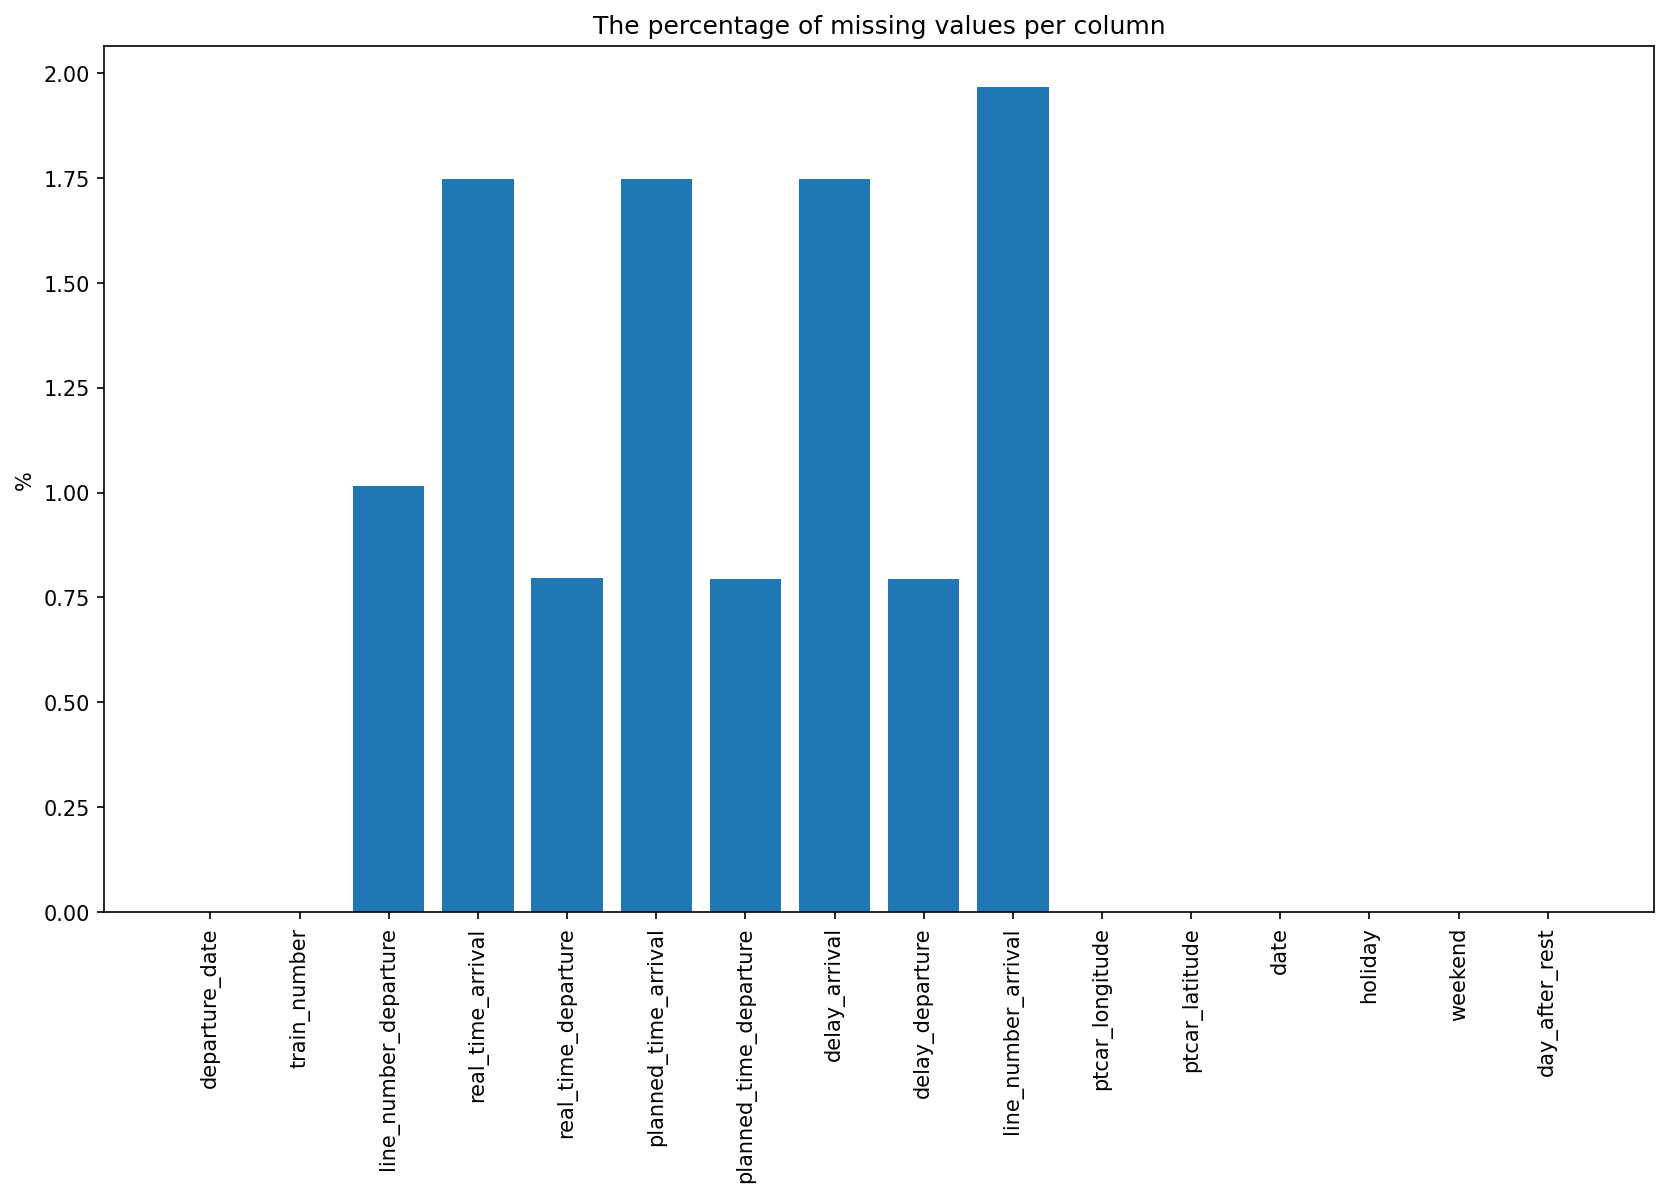

In [47]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.bar(merged_df.columns, merged_df.isna().sum() / merged_df.shape[0] * 100)
plt.xticks(rotation=90)
plt.ylabel("%")
plt.title("The percentage of missing values per column")
plt.show()

In [9]:
merged_df.loc[merged_df.index[::57], "delay_arrival"] = 0

merged_df.loc[merged_df.index[::57], "real_time_arrival"] = merged_df.loc[merged_df.index[::57], "real_time_departure"]
merged_df.loc[merged_df.index[::57], "planned_time_arrival"] = merged_df.loc[merged_df.index[::57], "planned_time_departure"]
merged_df.loc[merged_df.index[::57], "line_number_arrival"] = merged_df.loc[merged_df.index[::57], "line_number_departure"]


merged_df.loc[merged_df.index[56::57], "line_number_departure"] = 162
merged_df.loc[merged_df.index[56::57], "line_number_arrival"] = 162

index = merged_df.index[56::57]
mask = merged_df.loc[index, "real_time_departure"] == None
merged_df.loc[index, "real_time_departure"] = merged_df.loc[index, "real_time_arrival"]

mask = merged_df.loc[index, "planned_time_departure"] == None
merged_df.loc[index, "planned_time_departure"] = merged_df.loc[index, "planned_time_arrival"]

mask = merged_df.loc[index, "delay_departure"] == None
merged_df.loc[index, "delay_departure"] = merged_df.loc[index, "delay_arrival"]
print(merged_df.iloc[56::57])




        departure_date  train_number line_number_departure real_time_arrival  \
56          2017-06-11          2119                   162          22:29:07   
113         2017-06-11          2108                   162          11:31:01   
170         2017-06-11          2107                   162          10:27:24   
227         2017-06-11          2118                   162          21:28:23   
284         2017-06-11          2116                   162          19:27:39   
...                ...           ...                   ...               ...   
1558721     2024-04-12          2111                   162          14:21:59   
1558778     2024-04-12          2105                   162          08:33:33   
1558835     2024-04-12          2115                   162          18:22:03   
1558892     2024-04-12          2120                   162          23:21:36   
1558949     2024-04-12          2114                   162          17:44:41   

        real_time_departure planned_tim

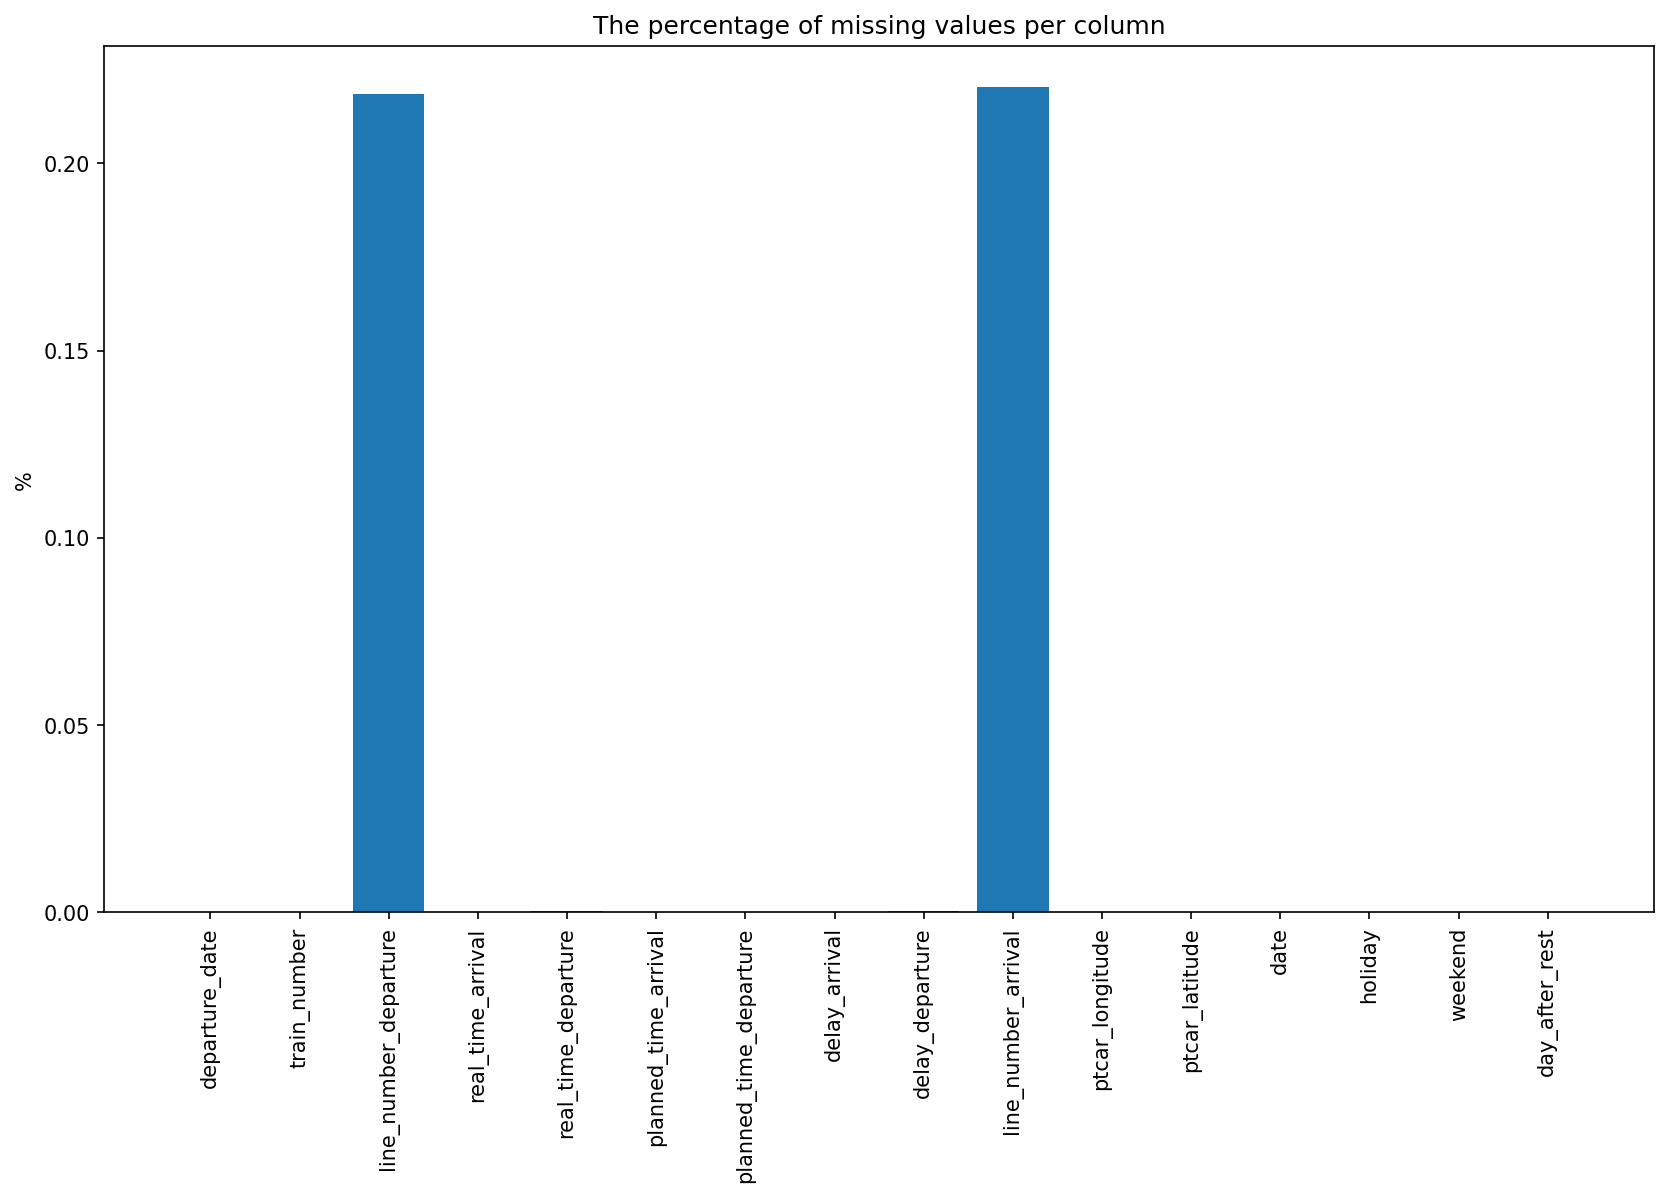

In [ ]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
ax.bar(merged_df.columns, merged_df.isna().sum() / merged_df.shape[0] * 100)
plt.xticks(rotation=90)
plt.ylabel("%")
plt.title("The percentage of missing values per column")
plt.show()

print(merged_df.isnull().sum())

In [11]:
query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)
print(weather.head())

         date  hour_of_day  avg_temperature  avg_dewpoint  \
0  2014-01-01          0.0         5.400000      3.845455   
1  2014-01-01          1.0         5.940000      4.150000   
2  2014-01-01          2.0         5.609091      3.681818   
3  2014-01-01          3.0         5.072727      3.145455   
4  2014-01-01          4.0         5.100000      3.118182   

   avg_relative_humidity  avg_precipitation  avg_snowfall  avg_wind_direction  \
0              90.818182           0.045455           0.0          208.181818   
1              89.300000           0.080000           0.0          210.000000   
2              88.454545           0.009091           0.0          212.727273   
3              88.545455           0.000000           0.0          206.363636   
4              88.000000           0.009091           0.0          200.000000   

   avg_wind_speed  avg_pressure  
0       18.327273   1009.318187  
1       18.360000   1009.379999  
2       18.000000   1009.945451  
3       17

In [12]:
merged_df['time'] = pd.to_datetime(merged_df['planned_time_arrival'], format='%H:%M:%S')

merged_df['hour'] = merged_df['time'].dt.hour


In [13]:
final_df = pd.merge(merged_df, weather, left_on=['departure_date', 'hour'], right_on=['date', 'hour_of_day'], how='left')

print(final_df.head())

final_df = final_df.drop(columns=['date_x', 'date_y', 'hour_of_day','time','hour'])
print(final_df.columns)


  departure_date  train_number line_number_departure real_time_arrival  \
0     2017-06-11          2119                   0/1          19:35:25   
1     2017-06-11          2119                   0/1          19:37:30   
2     2017-06-11          2119                   0/1          19:38:48   
3     2017-06-11          2119                   0/1          19:41:36   
4     2017-06-11          2119                   36N          19:43:27   

  real_time_departure planned_time_arrival planned_time_departure  \
0            19:35:25             19:33:00               19:33:00   
1            19:37:30             19:35:00               19:35:00   
2            19:39:51             19:36:00               19:37:00   
3            19:41:36             19:39:00               19:39:00   
4            19:45:12             19:41:00               19:43:00   

  delay_arrival  delay_departure line_number_arrival  ...      date_y  \
0           0.0            145.0                 0/1  ...  2017-06-

In [14]:
def parse_time_to_seconds(val):
    if pd.isna(val):
        return 0
    try:
        if isinstance(val, (int, float)):
            return int(val)
        if str(val).isdigit():
            return int(val)
        t = pd.to_datetime(val, format='%H:%M:%S', errors='coerce')
        if pd.isna(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0


final_df['departure_date'] = pd.to_datetime(final_df['departure_date'], format='%Y-%m-%d')

final_df['departure_year'] = final_df['departure_date'].dt.year
final_df['departure_month'] = final_df['departure_date'].dt.month
final_df['departure_day'] = final_df['departure_date'].dt.day
final_df['departure_weekday'] = final_df['departure_date'].dt.weekday

final_df['real_time_arrival'] = final_df['real_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_arrival'] = final_df['planned_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_departure'] = final_df['planned_time_departure'].apply(parse_time_to_seconds)
final_df['real_time_departure'] = final_df['real_time_departure'].apply(parse_time_to_seconds)

final_df = final_df.drop(columns=['departure_date', 'line_number_departure', 'line_number_arrival' ,'train_number'])

print(final_df.shape)
print(final_df.head())

(1558950, 23)
   real_time_arrival  real_time_departure  planned_time_arrival  \
0              70525                70525                 70380   
1              70650                70650                 70500   
2              70728                70791                 70560   
3              70896                70896                 70740   
4              71007                71112                 70860   

   planned_time_departure delay_arrival  delay_departure  ptcar_longitude  \
0                   70380           0.0            145.0         4.336052   
1                   70500         150.0            150.0         4.347843   
2                   70620         168.0            171.0         4.356758   
3                   70740         156.0            156.0         4.362220   
4                   70980         147.0            132.0         4.361252   

   ptcar_latitude  holiday  weekend  ...  avg_relative_humidity  \
0       50.835801        0     True  ...             

In [15]:
final_df['delay_arrival'] = final_df['delay_arrival'].apply(parse_time_to_seconds)
print(final_df.dtypes)


real_time_arrival           int64
real_time_departure         int64
planned_time_arrival        int64
planned_time_departure      int64
delay_arrival               int64
delay_departure           float64
ptcar_longitude           float64
ptcar_latitude            float64
holiday                     int64
weekend                      bool
day_after_rest               bool
avg_temperature           float64
avg_dewpoint              float64
avg_relative_humidity     float64
avg_precipitation         float64
avg_snowfall              float64
avg_wind_direction        float64
avg_wind_speed            float64
avg_pressure              float64
departure_year              int32
departure_month             int32
departure_day               int32
departure_weekday           int32
dtype: object
